# Bayesian Regression

Code implementing basic Bayesian regression (fixed basis) based on chapter 3of [Bishop's PRML](https://www.microsoft.com/en-us/research/people/cmbishop/prml-book/). 

(adapted from [https://github.com/amber-kshz/PRML](https://github.com/amber-kshz/PRML))

In [ ]:
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt


# Defining epsilon for limits
eps = 1e-15
    
# Configuring matplotlib
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,8)
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['lines.linewidth'] = 3.0
plt.style.use('dark_background')
plt.rcParams["image.cmap"] = 'Set3'

# Fix np.random seed for replicability
np.random.seed(0)

## Generating ground truth data

Sampling points from ground truth function with Gaussian noise

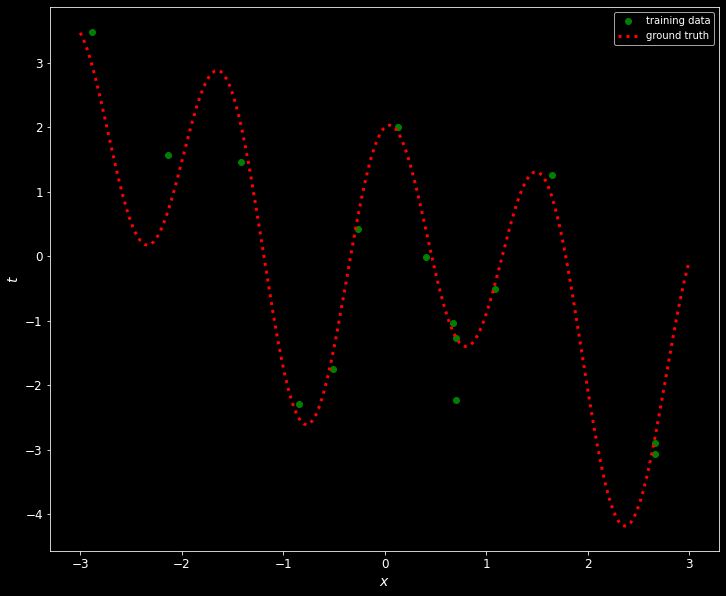

In [ ]:
def truef(x):
    return np.sin(2*x)  + 2*np.cos(4*x) - 0.5*x

x_min = -3
x_max = 3

N = 15
X = np.random.uniform(x_min,x_max, N)

beta_true = 4.0
ep = np.sqrt(1.0/beta_true)*np.random.randn(N)
t = truef(X) + ep

# Generate grid for plotting
Xcont = np.linspace(x_min,x_max,200) 

plt.figure(figsize=(12,10))
plt.plot(X, t,'og', label='training data')
plt.plot(Xcont, truef(Xcont), ':r',label='ground truth')
plt.xlabel(r'$x$')
plt.ylabel(r'$t$')
plt.legend()
plt.show()

X = np.reshape(X,(len(X),1))
Xtest = np.reshape(Xcont,(len(Xcont),1))

# Bayesian linear regression (fixed basis)

## Defining basis functions for Bayesian linear regression

For this demo, we use Gaussian basis functions:
$$
\begin{align}
    &{} \phi_0 (x) = 1 \\
    &{} \phi_j(x) = \exp\left[ -\frac{(x-\mu_j)^2}{2 s^2} \right] \ \ (j = 1, \dots, M-1), 
\end{align}
$$
where we choose the hyperparameters $\mu_j$ to be at regular intervals on the domain $[-3,3]$, and either fix or optimize over the common scale parameter $s$.

In [ ]:
def Phi_gaussian(X, params):
    """
    Generates a design matrix with Gaussian basis functions
    
    Parameters
    ----------
    X :  (N,d) numpy array
        X[n, i] = i-th element of x_n
    
    params : dictionary
        Dictionary of parameters of Gaussian basis function with
        params['mus'] : (M-1,d) numpy array. params['mus'][j] = center of the jth Gaussian basis fn
        params['s'] : double. positive real number, scale (width) of Gaussian basis fns
    
    Returns
    ----------
    Phi: 2-D numpy array
        (N,M) array, with Phi[n, m] = $\phi_m(x_n)$
    
    """
    
    s = params['s'] 
    mus = params['mus']
    Phi = np.zeros((len(X),len(mus)+1))
    Phi[:,0] = np.ones(len(X)) # the 0-the basis is constant 1
    A = ( -2*(X@(mus.T)) + np.reshape(np.sum(X**2, axis=1), (len(X), -1)) ) + np.sum(mus**2, axis=1)
    Phi[:,1:] = np.exp(-A/(2*s*s))
    return Phi

def plot_result(ax,pred_mean, pred_std):
    ax.plot(X, t,'og',label='training data')
    ax.plot(Xcont, pred_mean, label='predictive mean')
    ax.plot(Xcont, truef(Xcont), ':r', label='ground truth')
    ax.fill_between(Xcont, pred_mean + 2.0*pred_std, pred_mean - 2.0*pred_std, alpha=0.2)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$t$')
    plt.legend()


def plot_prediction_fixed_hparams(ax,s, mus, alpha, beta):
    # generating design matrix
    Phi = Phi_gaussian(X,params={'s':s, 'mus':mus})
    Phi_test = Phi_gaussian(Xtest,params={'s':s, 'mus':mus})
    
    est = BayesianRegression(alpha=alpha, beta=beta)
    est.fit(Phi, t, optimize_hyperparams=False)
    pred_mean, pred_std = est.predict(Phi_test, return_std=True)
    plot_result(ax,pred_mean, pred_std)    

In [ ]:
class BayesianRegression:
    
    def __init__(self, alpha=1.0, beta=1.0):
        self.alpha = alpha
        self.beta = beta
        self.m = None # posterior mean
        self.S = None # posterior covariance matrix
        self.T = None # posterior inverse covariance matrix
        
    
    def calc_posterior_params(self, Phi, t):
        """
        Compute posterior mean and covariance matrix from data Phi,t
        
        Parameters
        ----------
        Phi : 2-D numpy array
            (N,M) array, representing design matrix
        t : 1-D numpy array
            (N,) array, representing target values
        """
        self.T = self.alpha*np.identity(len(Phi[0])) + self.beta*(Phi.T)@Phi
        self.S = np.linalg.inv(self.T)
        self.m = self.beta * ( self.S @ (Phi.T) @ t)


    def predict(self, Phi, return_std=False):
        """
        Returns predictive mean and standard deviation
        
        Parameters
        ----------
        Phi : 2-D numpy array
            (N_test, M) numpy array. M must be equal to "M" (the length in the second dimension) of the training data.
        return_std : boolean, default False
            If True, the method also returns predictive standard deviation
            
        Returns 
        ----------
        pred_mean : 1-D numpy array
            (N_test,) numpy array representing predictive mean
        pred_std : 1-D numpy array
            (N_test,) numpy array representing predictive mean
        """
        pred_mean = Phi @ self.m
        if not(return_std):
            return pred_mean
        else:
            pred_std = np.sqrt(1.0/self.beta + np.diag(Phi @ self.S @ (Phi.T ) ))
            return pred_mean, pred_std
        
        
    def calc_evidence(self, Phi, t):
        """
        Calculate evidence with respect to the data 
        
        Parameters
        ----------
        Phi : 2-D numpy array
            (N,M) array, representing design matrix
        t : 1-D numpy arra
            (N,) array, representing target values
            
        Returns
        ----------
        evidence : float
        
        """
        N, M = np.shape(Phi)
        evidence = 0.5*M*np.log(self.alpha) + 0.5*N*np.log(self.beta) \
            - 0.5*self.beta*np.linalg.norm( t - Phi @ self.m )**2 - 0.5*self.alpha*(self.m@self.m) \
            - 0.5*np.log( np.linalg.det( self.alpha*np.identity(M) + self.beta*(Phi.T)@Phi ) ) \
            - 0.5*N*np.log(2*np.pi)
        return evidence
                
    
    def empirical_bayes(self, Phi, t, tol, maxiter, show_message=True):
        """
        Hyperparameter tuning via empirical bayes (or evidence approximation)
        
        Parameters
        ----------
        Phi : 2-D numpy array
            (N,M) array, representing design matrix
        t : 1-D numpy arra
            (N,) array, representing target values
        tol : float
            Tolerance: if changes in hyperparams smaller than tol, stop iteration
        maxiter : int
            Maximum number of iteration
        show_message : boolean, default True
            If True, the message indicating whether the optimization terminated successfully is shown.
        """
        N = len(t)
        phi_eigs = np.linalg.eigh((Phi.T)@Phi)[0]
        cnt = 0
        while cnt < maxiter:
            self.calc_posterior_params(Phi, t)
            
            alpha_old = self.alpha
            beta_old = self.beta
            
            gamma = np.sum( self.beta * phi_eigs/ (self.alpha + self.beta * phi_eigs) )
            self.alpha = gamma/np.dot(self.m, self.m)
            self.beta = (N - gamma) / ( np.linalg.norm(t -  Phi @ self.m )**2 )
            if (abs(self.alpha - alpha_old) < tol) and ( abs(self.beta - beta_old) < tol ):
                break
            cnt += 1
        if show_message:
            if cnt <= maxiter:
                print(f"Optimization terminated succesfully. Number of iters : {cnt}")
            else:
                print("Maximum number of iters exceeded.")
                
    def fit(self, Phi, t, tol=1e-4, maxiter=100, show_message=True, optimize_hyperparams=False):
        """
        Fits model to data (with/without empirical Bayes)

        Parameters
        ----------
        Phi : 2-D numpy array
            (N,M) array, representing design matrix
        t : 1-D numpy arra
            (N,) array, representing target values
        tol : float
            tolerance for empirical Bayes
        maxiter : int
            maximum number of iterations for empirical Bayes
        show_message : boolean, default True
            If True, the message indicating whether the optimization terminated successfully is shown.
        optimize_hyperparams : boolean, default False
            If True, the hyper parameters alpha and beta are optimized by empirical Bayes.
        """
        if optimize_hyperparams:
            self.empirical_bayes(Phi, t, tol, maxiter, show_message)
        self.calc_posterior_params(Phi, t)            

## Bayesian regression with fixed hyperparameters

We first see how different hyperparameter settings work for fitting the data.

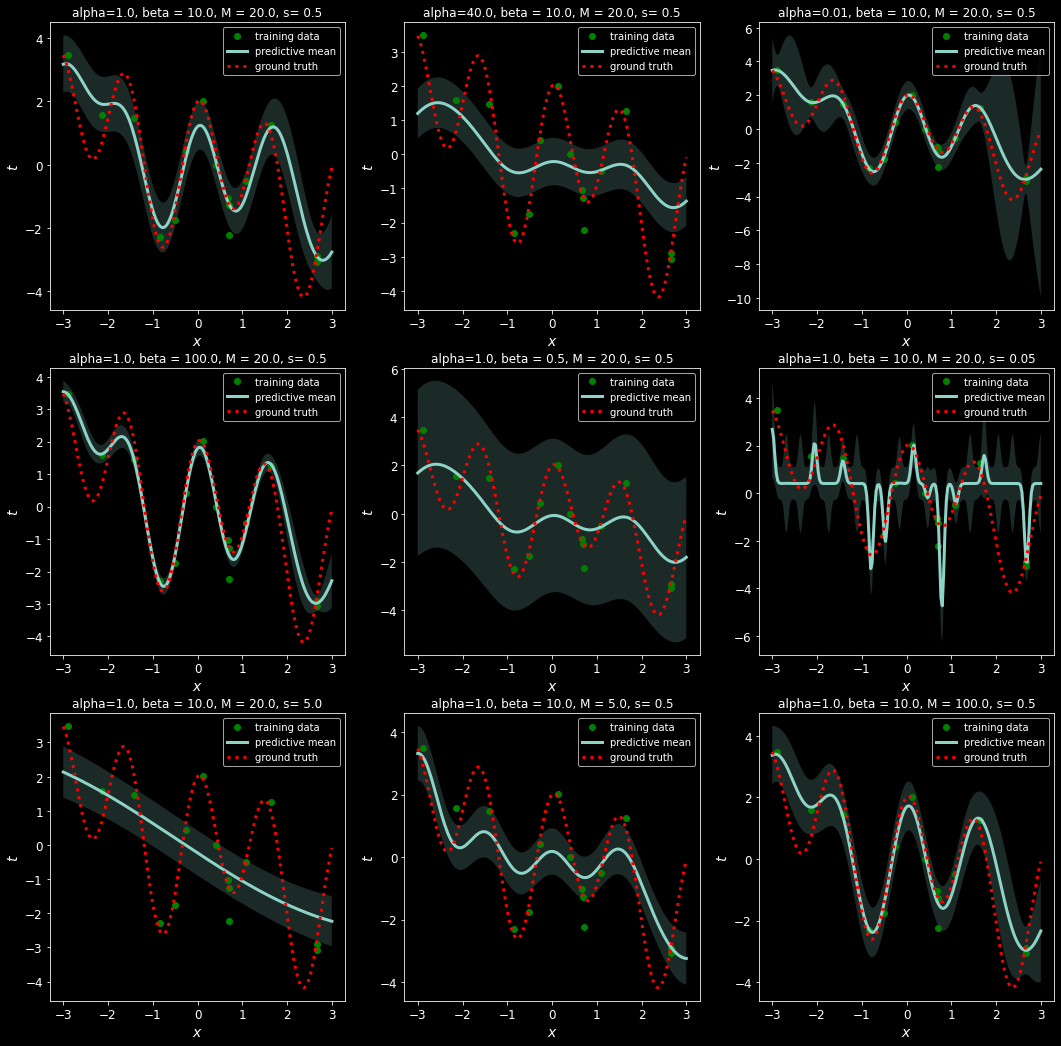

In [ ]:
# Array of hyperparameters (M,s,alpha,beta)
Hyperparams = np.array([[20, 0.5, 1.0, 10.0],
                        [20, 0.5, 40.0, 10.0],
                        [20, 0.5, 0.01, 10.0],
                        [20, 0.5, 1.0, 100.0],
                        [20, 0.5, 1.0, 0.5],
                        [20, 0.05, 1.0, 10.0],
                        [20, 5.0, 1.0, 10.0],
                        [5, 0.5, 1.0, 10.0],
                        [100, 0.5, 1.0, 10.0]
                ])

fig = plt.figure(figsize=(18,18))
cnt = 0
while cnt < len(Hyperparams):
    M,s,alpha,beta = Hyperparams[cnt]

    ax = fig.add_subplot(3, 3, cnt+1)
    mus = np.reshape(np.linspace(x_min,x_max,int(M)),(int(M),1))
    plot_prediction_fixed_hparams(ax,s, mus, alpha=alpha, beta=beta)

    ax.set_title(f"alpha={alpha}, beta = {beta}, M = {M}, s= {s}")
    cnt += 1
plt.show()

## Bayesian linear regression with empirical Bayes tuning

## Optimizing for $\alpha$ and $\beta$ (with fixed $s$ and $M$)

Next, we 'tune' the hyperparameters $\alpha, \beta, s, M$ using the empirical Bayes heuristic (a.k.a. 'evidence approximation'; see Bishop, Section 3.5). For fixed $(s,M)$, we can solve for the optimal $(\alpha,\beta)$.

Optimization terminated succesfully. Number of iters : 24
alpha=0.2856544554024625 
beta=5.3192970772148245


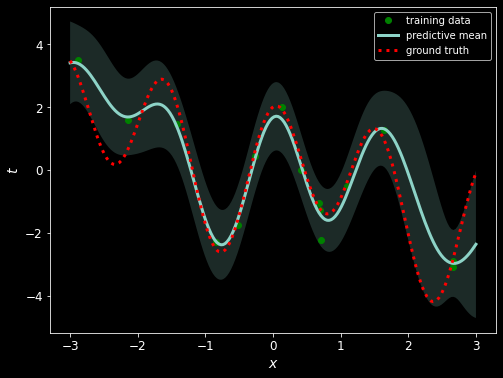

In [ ]:
M = 50; s = 0.5
mus = np.reshape(np.linspace(x_min,x_max,M),(M,1))

params = {'s':s, 'mus':mus}
Phi = Phi_gaussian(X, params = {'s':s, 'mus':mus})
Phi_test = Phi_gaussian(Xtest,params={'s':s, 'mus':mus})

est = BayesianRegression(alpha=1.0, beta=1.0)
est.fit(Phi, t, optimize_hyperparams=True)
pred_mean, pred_std = est.predict(Phi_test, return_std=True)

fig = plt.figure(figsize=(8,6))
ax = fig.subplots(1,1)
print(f"alpha={est.alpha} \nbeta={est.beta}")
plot_result(ax,pred_mean, pred_std)

### Optimizing for $s$

Next, for $s$, we can do a line search to find the highest evidence for the data (for each $s$, we use the previous section to find optimal $\alpha,\beta$).

s_opt=0.3125


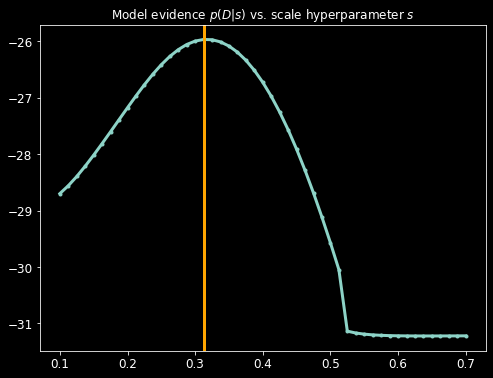

In [ ]:
M = 50
mus = np.reshape(np.linspace(x_min, x_max, M), (M, 1))

ss = np.linspace(0.1, 0.7, 49)
arr_evidence = np.zeros(len(ss))

for (cnt,s) in enumerate(ss):
    Phi = Phi_gaussian(X, {'s':s, 'mus':mus})
    est = BayesianRegression(alpha=1.0, beta=1.0)
    est.fit(Phi, t, tol=1e-4, maxiter=1e3, optimize_hyperparams=True, show_message=False)
    arr_evidence[cnt] = est.calc_evidence(Phi, t)

s_opt = ss[np.argmax(arr_evidence)]

print(f"s_opt={s_opt}")
plt.figure(figsize=(8,6))
plt.plot(ss,arr_evidence,'.-')
plt.axvline(s_opt,color='orange')
plt.title('Model evidence $p(D|s)$ vs. scale hyperparameter $s$')
plt.show()

Optimization terminated succesfully. Number of iters : 5
s=0.3125
alpha=0.9020550242073939 
beta=5.878830558207263


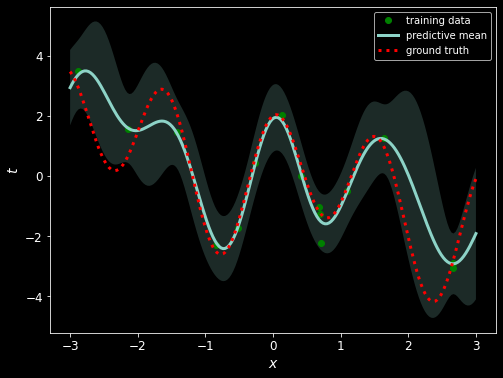

In [ ]:
params = {'s':s_opt, 'mus':mus}
Phi = Phi_gaussian(X, params = {'s':s_opt, 'mus':mus})
Phi_test = Phi_gaussian(Xtest,params={'s':s_opt, 'mus':mus})

est = BayesianRegression(alpha=1.0, beta=1.0)
est.fit(Phi, t, optimize_hyperparams=True)
pred_mean, pred_std = est.predict(Phi_test, return_std=True)

fig = plt.figure(figsize=(8,6))
ax = fig.subplots(1,1)
print(f"s={s_opt}\nalpha={est.alpha} \nbeta={est.beta}")
plot_result(ax,pred_mean, pred_std)


Similarly we can optimize for $M$; here we do it with fixed $s$ for demonstration, but we can also jointly optimize via a 2d grid search.

M_opt=200


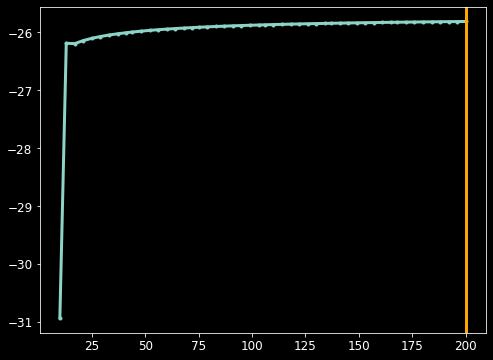

In [ ]:
s = s_opt

M_array = np.linspace(10,200,dtype=int)
arr_evidence = np.zeros(len(M_array))

for (cnt,M) in enumerate(M_array):
    mus = np.reshape(np.linspace(x_min,x_max,M),(M,1))
    Phi = Phi_gaussian(X, {'s':s, 'mus':mus})
    est = BayesianRegression(alpha=1.0, beta=1.0)
    est.fit(Phi, t, tol=1e-3, maxiter=1e4, optimize_hyperparams=True, show_message=False)
    arr_evidence[cnt] = est.calc_evidence(Phi, t)

M_opt = M_array[np.argmax(arr_evidence)]

print(f"M_opt={M_opt}")
plt.figure(figsize=(8,6))
plt.plot(M_array,arr_evidence,'.-')
plt.axvline(M_opt,color='orange')
plt.show()

Using the previous value of $M$, we re-optimize for $s,\alpha,\beta$ and plot the posterior

/usr/local/lib/python3.7/dist-packages/numpy/linalg/linalg.py:2159: RuntimeWarning: overflow encountered in det
  r = _umath_linalg.det(a, signature=signature)


Optimization terminated succesfully. Number of iters : 4
s=0.3125
alpha=3.544174408466552 
beta=5.854301570207701


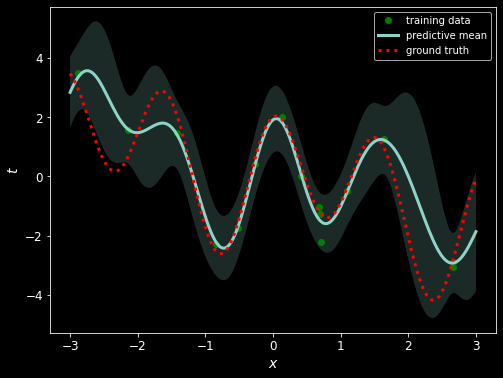

In [ ]:
M = M_opt
mus = np.reshape(np.linspace(x_min,x_max,M),(M,1))


ss = np.linspace(0.1, 0.7, 49)
arr_evidence = np.zeros(len(ss))
for (cnt,s) in enumerate(ss):
    Phi = Phi_gaussian(X, {'s':s, 'mus':mus})
    est = BayesianRegression(alpha=1.0, beta=1.0)
    est.fit(Phi, t, tol=1e-4, maxiter=1e3, optimize_hyperparams=True, show_message=False)
    arr_evidence[cnt] = est.calc_evidence(Phi, t)
s_opt = ss[np.argmax(arr_evidence)]

params = {'s':s_opt, 'mus':mus}
Phi = Phi_gaussian(X, params = {'s':s_opt, 'mus':mus})
Phi_test = Phi_gaussian(Xtest,params={'s':s_opt, 'mus':mus})

est = BayesianRegression(alpha=1.0, beta=1.0)
est.fit(Phi, t, optimize_hyperparams=True)
pred_mean, pred_std = est.predict(Phi_test, return_std=True)

fig = plt.figure(figsize=(8,6))
ax = fig.subplots(1,1)
print(f"s={s_opt}\nalpha={est.alpha} \nbeta={est.beta}")
plot_result(ax,pred_mean, pred_std)

## Bayesian linear regression using scikit-learn

There are many packages which imlpement Bayesian regression in Python. Below we perform the above steps using the implementation given in Scikit-Learn (https://scikit-learn.org/stable/modules/linear_model.html#bayesian-regression)

s=0.3125
alpha=3.544173173339641 
beta=5.854288117820579


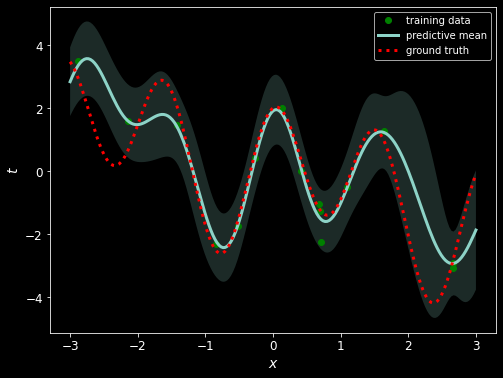

In [ ]:
from sklearn.linear_model import BayesianRidge

reg = BayesianRidge(fit_intercept=False)

# prepare the design matrix
mus = np.reshape(np.linspace(x_min, x_max, M_opt), (M_opt, 1))
params = {'s':s_opt, 'mus':mus}
Phi = Phi_gaussian(X, params = {'s':s_opt, 'mus':mus})

# perform the fitting (optimization with respect to alpha and beta is also performed)
reg.fit(Phi, t)

Phi_test = Phi_gaussian(Xtest, params)
pred_mean,pred_std = reg.predict(Phi_test, return_std=True)

fig = plt.figure(figsize=(8,6))
ax = fig.subplots(1,1)
print(f's={s_opt}\nalpha={reg.lambda_} \nbeta={reg.alpha_}')
plot_result(ax,pred_mean, pred_std)
plt.show()